In [8]:
import pandas as pd
import nltk
import pickle

import glob
import pytextrank
from collections import Counter
from operator import itemgetter 
import string
from os import path
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora,models
from gensim.models import LdaModel, LsiModel

# spacy for lemmatization
import spacy
from spacy.lang.en import English

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Widen the dataframe to show the long cells
pd.set_option('display.max_colwidth', 200)

In [2]:
data=pd.read_csv('noDup_data.csv')

In [90]:
leng=[len(i) for i in d]

In [103]:
dd=data.replace(to_replace='None', value=np.nan).dropna()

In [104]:
dd['time_date'].sort_values(ascending=False)

384    2018-01-09
60     2018-01-07
432    2018-01-03
789    2018-01-03
463    2018-01-03
          ...    
797    2017-10-24
798    2017-10-24
802    2017-10-24
810    2017-10-24
837    2017-10-24
Name: time_date, Length: 592, dtype: object

In [91]:
d[]

2838.705463182898

In [114]:
data[data['sections_simple']=='opinion']['content']

6      THE OPPORTUNITY for citizens to vote for their favorite candidates is often taken for granted in the United States, but not in many other parts of the world. The result is that a majority of eligi...
7                           I can't wait for Wednesday, when TV ads will go back to being about the wonder drugs that can prolong my life if the side effects don't kill me first.  Andy Virga  Virginia Beach
8      The consequences of sea-level rise and flooding from more powerful storms are being ignored by city leaders, residents and the Navy. Norfolk and the rest of Hampton Roads are experiencing the high...
9      The process of changing school attendance zones is both emotional and politically challenging. The Pilot's recent stories about the Chesapeake School Board rezoning decision clearly demonstrate th...
10     I am an avid reader and consumer of news. It is becoming increasingly difficult, though, to see so many negative headlines and stories every day. The level of incivi

In [115]:
data['content'].iloc[6]

'THE OPPORTUNITY for citizens to vote for their favorite candidates is often taken for granted in the United States, but not in many other parts of the world. The result is that a majority of eligible voters in Virginia and elsewhere routinely skip elections, leaving those important decisions to others.  Today will be no exception. Analysts predict that only 40 to 45 percent of the commonwealth\'s registered voters will take part in today\'s elections of local and statewide candidates, a disappointing forecast but one that is consistent with other years when there\'s no presidential race on the ballot.  Bad weather can cause those numbers to drop even lower, and the predictions of steady rain and highs in the 50s for Hampton Roads likely will keep additional voters away, though perhaps it will affect only a small percentage of people.  The races this year are too important to neglect, or to let a little rain dampen the turnout. Virginians today are choosing their next governor, lieuten

In [3]:
d=data.content.to_list()
sec=data.section.to_list()

In [5]:
from nltk.corpus import stopwords
stop_words= stopwords.words('english')

In [6]:
data_words=[]
for sentence in d:
    word=gensim.utils.simple_preprocess(sentence, deacc=True)
    stop=[]
    for i in word:
        if i not in stop_words:
            stop.append(i)
    data_words.append(stop)

In [7]:
data_words[:2]

[['spaghetti',
  'westerns',
  'box',
  'office',
  'smashes',
  'thanks',
  'italian',
  'directors',
  'like',
  'sergio',
  'leone',
  'could',
  'bring',
  'outlaws',
  'saloons',
  'gunfights',
  'life',
  'big',
  'screen',
  'cheaply',
  'making',
  'movies',
  'europe',
  'original',
  'spaghetti',
  'western',
  'come',
  'years',
  'earlier',
  'giacomo',
  'puccini',
  'unveiled',
  'opera',
  'girl',
  'golden',
  'west',
  'says',
  'lillian',
  'groag',
  'returns',
  'virginia',
  'opera',
  'direct',
  'girl',
  'see',
  'puccini',
  'opera',
  'expect',
  'certain',
  'thing',
  'groag',
  'says',
  'instead',
  'saloon',
  'broken',
  'bottles',
  'flying',
  'gunfights',
  'great',
  'fun',
  'puccini',
  'always',
  'attracted',
  'cultures',
  'evidenced',
  'works',
  'madame',
  'butterfly',
  'turandot',
  'became',
  'fascinated',
  'west',
  'trip',
  'new',
  'york',
  'city',
  'saw',
  'play',
  'name',
  'inspired',
  'opera',
  'love',
  'america',
  'saw

### Bigram /Trigram

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stop_words, ngram_range=(2,4))
ngrams = c_vec.fit_transform(data['content'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [75]:
df_ngram.head(10)

,frequency,bigram/trigram
0,578,virginia beach
1,349,hampton roads
2,242,class region
3,150,oscar smith
4,138,great bridge
5,126,king fork
6,124,norfolk academy
7,120,ocean lakes
8,119,last year
9,114,high school


In [9]:
data_lemma=[]
nlp = spacy.load("en_core_web_sm")
for sent in data_words:
    doc = nlp(" ".join(sent)) 
    data_lemma.append([token.lemma_ for token in doc])

In [10]:
data_lemma[:3]

[['spaghetti',
  'westerns',
  'box',
  'office',
  'smash',
  'thanks',
  'italian',
  'director',
  'like',
  'sergio',
  'leone',
  'could',
  'bring',
  'outlaws',
  'saloon',
  'gunfight',
  'life',
  'big',
  'screen',
  'cheaply',
  'make',
  'movie',
  'europe',
  'original',
  'spaghetti',
  'western',
  'come',
  'year',
  'early',
  'giacomo',
  'puccini',
  'unveil',
  'opera',
  'girl',
  'golden',
  'west',
  'say',
  'lillian',
  'groag',
  'return',
  'virginia',
  'opera',
  'direct',
  'girl',
  'see',
  'puccini',
  'opera',
  'expect',
  'certain',
  'thing',
  'groag',
  'say',
  'instead',
  'saloon',
  'broken',
  'bottle',
  'fly',
  'gunfight',
  'great',
  'fun',
  'puccini',
  'always',
  'attract',
  'culture',
  'evidence',
  'works',
  'madame',
  'butterfly',
  'turandot',
  'become',
  'fascinated',
  'west',
  'trip',
  'new',
  'york',
  'city',
  'see',
  'play',
  'name',
  'inspire',
  'opera',
  'love',
  'america',
  'see',
  'play',
  'huge',
  '

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemma)

# Create Corpus
texts = data_lemma

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True
)

In [88]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.120497 -0.219796       1        1  47.653801
3      0.018235 -0.368731       2        1  16.537603
5     -0.392005 -0.038767       3        1   8.963999
8     -0.193788  0.331950       4        1   8.561154
4      0.330502 -0.156408       5        1   7.403259
0      0.325805  0.137314       6        1   4.385581
2      0.129050  0.310120       7        1   2.530670
9     -0.233286 -0.207978       8        1   1.962502
1     -0.137627  0.121527       9        1   1.954858
6      0.032617  0.090769      10        1   0.046572, topic_info=             Term         Freq        Total Category  logprob  loglift
174           say  3517.000000  3517.000000  Default  30.0000  30.0000
204      virginia  1314.000000  1314.000000  Default  29.0000  29.0000
1736         game   764.000000   764.000000  Default  28.0000  28.0000
1490       police   342.000000   342.000000  Default  27.0000  27.0000
241      business   292.000000   292.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4501  cheerleader     0.005686     2.309887  Topic10  -9.8266   1.6650
4497     anecdote     0.005686     2.474368  Topic10  -9.8267   1.5962
4507      jubilee     0.005686     2.478427  Topic10  -9.8267   1.5946
3923     krasnoff     0.005686    10.039883  Topic10  -9.8267   0.1956
4499      beloved     0.005686     2.927179  Topic10  -9.8267   1.4281

[598 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
953       3  0.993459  academy
1693      2  0.985911      acc
1544      1  0.657930   accord
1544      6  0.232023   accord
1544      9  0.108066   accord
...     ...       ...      ...
220       1  0.859546     year
220       2  0.069894     year
220       3  0.013384     year
220       4  0.011897     year
220       5  0.044613     year

[911 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 6, 9, 5, 1, 3, 10, 2, 7])

### LDA Mallet

In [14]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME']=r'C:\Users\yueyu\mallet-2.0.8'
mallet_path =r'C:\Users\yueyu\mallet-2.0.8\bin\mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemma, start=2, limit=30, step=6)

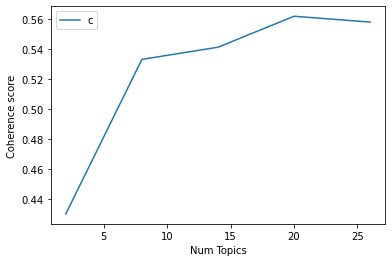

In [17]:
# Show graph
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
pyLDAvis.enable_notebook()
optimal_model=model_list[3]
optmodel_20 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis_20 = pyLDAvis.gensim.prepare(optmodel_20, corpus, id2word, mds='mmds')
vis_20

C:\Users\yueyu\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\yueyu\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\yueyu\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.030384  0.242978       1        1  6.656410
13     0.299708 -0.312076       2        1  6.296988
2     -0.124693  0.041661       3        1  6.215560
17     0.032466  0.471928       4        1  5.646493
4      0.117054 -0.058251       5        1  5.573444
8      0.429028  0.021425       6        1  5.299246
14     0.267442  0.404152       7        1  5.278853
5     -0.418349 -0.224389       8        1  5.030043
1     -0.329813  0.167278       9        1  4.965198
7      0.237937  0.185942      10        1  4.923020
11     0.416053  0.205644      11        1  4.882039
12    -0.145632  0.373157      12        1  4.836867
18    -0.476640  0.066792      13        1  4.759342
6     -0.307405  0.386258      14        1  4.646706
0      0.187314 -0.389672      15        1  4.646053
19    -0.342163 -0.112954      16        1  4.585485
15    -0.220078 -0.424329      17        1  4.180256
9     -0.076960 -0.343188      18        1  4.095520
16    -0.003038 -0.481778      19        1  3.914791
3      0.427386 -0.220580      20        1  3.567686, topic_info=          Term         Freq        Total Category  logprob  loglift
204   virginia  1538.000000  1538.000000  Default  30.0000  30.0000
1284       run   936.000000   936.000000  Default  29.0000  29.0000
1736      game   912.000000   912.000000  Default  28.0000  28.0000
1313     beach   770.000000   770.000000  Default  27.0000  27.0000
1408    school   678.000000   678.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
934     league    50.810728   135.858926  Topic20  -5.0675   2.3497
1781     point    55.767872   326.988981  Topic20  -4.9744   1.5645
1636      pass    47.092870   498.891742  Topic20  -5.1435   0.9730
1748    injury    45.853584   146.724537  Topic20  -5.1702   2.1701
1284       run    47.092870   936.780374  Topic20  -5.1435   0.3429

[1854 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
222        1  0.646481        -PRON-
222       14  0.352626        -PRON-
1049      17  0.911882         abbie
10538     16  0.874694    abbreviate
11489      6  1.105307  abdusamatova
...      ...       ...           ...
1048      17  0.911882       zachery
10471      8  0.840554       zealand
8517       9  0.858924        zehner
7827       8  1.008665          zhou
9040       9  0.858924          zook

[2902 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 14, 3, 18, 5, 9, 15, 6, 2, 8, 12, 13, 19, 7, 1, 20, 16, 10, 17, 4])

### Dominant Topics for each Article

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=d):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    section=pd.Series(sec)
    sent_topics_df = pd.concat([sent_topics_df, contents,section], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=d)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords','Text','Section']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Section
0,0,6.0,0.3903,"story, book, life, lead, american, -PRON-, make, day, world, medium","In the 1960s, spaghetti Westerns were box office smashes thanks to Italian directors like Sergio Leone, who could bring outlaws, saloons and gunfights to life on the big screen cheaply by making m...",entertainment/arts/theater
1,1,6.0,0.3053,"story, book, life, lead, american, -PRON-, make, day, world, medium","Even five years after his death, Hanns Loewenbach's message remains true: Bigotry thrives not only because of hate, but because others see it and do nothing. Loewenbach, a local Holocaust survivo...",entertainment
2,2,6.0,0.3410,"story, book, life, lead, american, -PRON-, make, day, world, medium","That blip of a generation known as X, born roughly between 1964 and 1982 ,including yours truly , is accustomed to being overlooked. That's always been our chief gripe, but it's also been a blessi...",entertainment/tv
3,3,0.0,0.3889,"state, tech, game, team, miami, virginia, coach, season, football, conference","today's highlights ON THE AIR College football Kent State at Western Michigan, 7 p.m., CBSSN Toledo at Ohio, 7 p.m., ESPN2 Eastern Michigan at Central Michigan, 8 p.m., ESPNU Golf Blue ...",sports/tv-listings
4,4,15.0,0.6695,"norfolk, academy, tournament, suffolk, henry, nansemond, colonial, conference, cape, score","Boys volleyball All-Region Multiclass 1-4 First team Nathan McGhee ,Heritage , George Giles ,Heritage , Tommy Speelman ,Great Bridge , Miking Johnson ,Heritage , Elijah Morris ,Heritage , ...",sports/high-school/scores
5,5,15.0,0.7105,"norfolk, academy, tournament, suffolk, henry, nansemond, colonial, conference, cape, score","Field hockey All-Southeastern District First team Forwards: Peyton Tollaksen ,Great Bridge , Gabe Lechner ,Hickory , Ashlyn Rogers ,Nansemond River , Chloe Underwood ,Great Bridge , Faith ...",sports/high-school/scores
6,6,4.0,0.4914,"virginia, state, election, candidate, support, district, vote, republican, year, voter","THE OPPORTUNITY for citizens to vote for their favorite candidates is often taken for granted in the United States, but not in many other parts of the world. The result is that a majority of eligi...",opinion/editorial
7,7,6.0,0.0744,"story, book, life, lead, american, -PRON-, make, day, world, medium","I can't wait for Wednesday, when TV ads will go back to being about the wonder drugs that can prolong my life if the side effects don't kill me first. Andy Virga Virginia Beach",opinion/letters
8,8,7.0,0.2326,"navy, year, norfolk, shipyard, military, naval, ship, uss, rise, water","The consequences of sea-level rise and flooding from more powerful storms are being ignored by city leaders, residents and the Navy. Norfolk and the rest of Hampton Roads are experiencing the high...",opinion/letters
9,9,1.0,0.3337,"school, student, high, university, percent, virginia, board, community, teacher, college",The process of changing school attendance zones is both emotional and politically challenging. The Pilot's recent stories about the Chesapeake School Board rezoning decision clearly demonstrate th...,opinion/letters


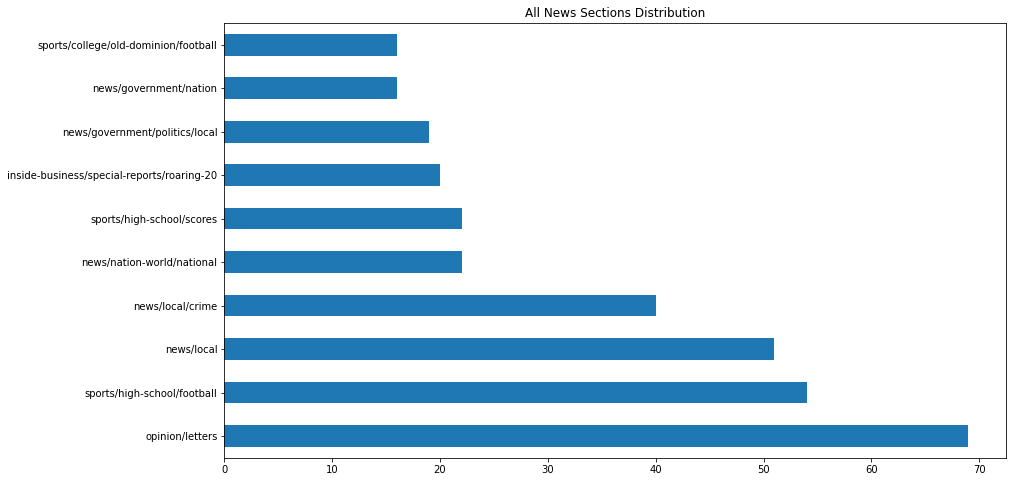

In [78]:
df_dominant_topic['Section'].value_counts().head(10).plot.barh(
                                    figsize=(14,8), title='All News Sections Distribution')

In [83]:
def topic(num):
    df_section=df_dominant_topic[['Document_No','Dominant_Topic','Keywords','Section']]
    topic=df_section[df_section['Dominant_Topic']==num][['Keywords','Section']]
    show=topic['Section'].value_counts().sort_values(ascending=False)
    print('Keyword in topic '+str(num)+' : '+topic['Keywords'].iloc[1])
    topic['Section'].value_counts().plot.barh(
                                    figsize=(14,6),
                                    title="News Section Distribution in Topic "+ str(num),rot=0)

Keyword in topic 1 : school, student, high, university, percent, virginia, board, community, teacher, college


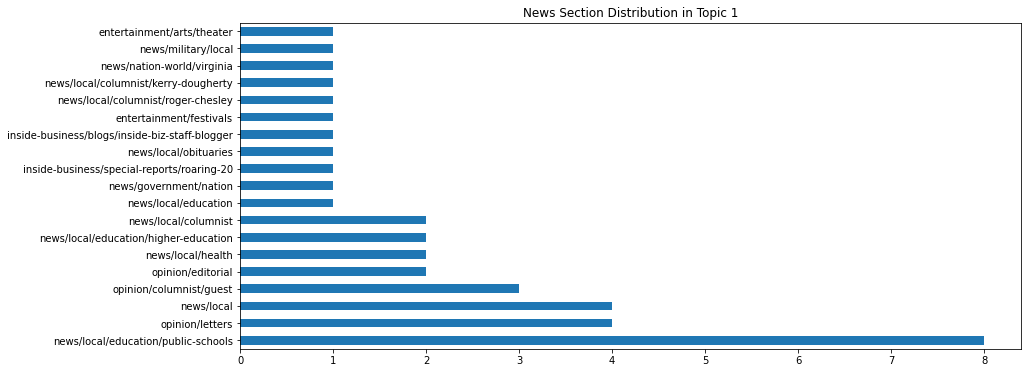

In [84]:
topic(1)

Keyword in topic 3 : rank, week, team, sunday, game, average, player, season, back, oak


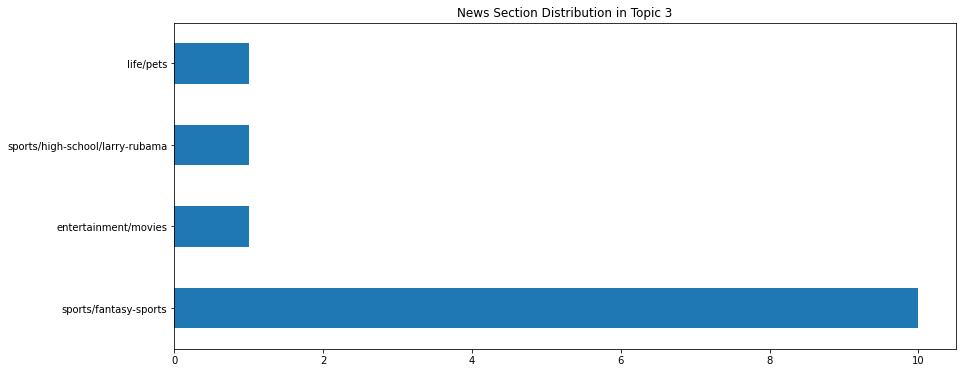

In [109]:
topic(3)

Keyword in topic 9 : class, region, smith, team, king, top, friday, taylor, oscar, fork


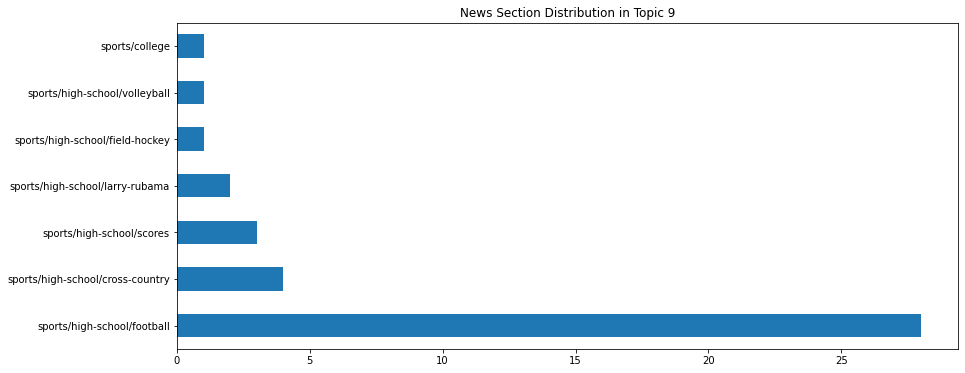

In [111]:
topic(9)

### Topic distribution across articles

In [110]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
df_dominant_topics=df_dominant_topics.sort_values(by=['Num_Documents'],ascending=False).reset_index(drop=True)
# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,9.0,"class, region, smith, team, king, top, friday, taylor, oscar, fork",80,0.0950
1,5.0,"plan, pay, percent, cost, tax, million, bill, change, money, month",67,0.0796
2,7.0,"navy, year, norfolk, shipyard, military, naval, ship, uss, rise, water",64,0.0760
3,16.0,"run, kick, pass, county, class, fail, return, river, christian, james",58,0.0689
4,15.0,"norfolk, academy, tournament, suffolk, henry, nansemond, colonial, conference, cape, score",56,0.0665
5,6.0,"story, book, life, lead, american, -PRON-, make, day, world, medium",53,0.0629
6,17.0,"people, family, child, year, home, day, friend, live, love, young",50,0.0594
7,18.0,"restaurant, food, visit, offer, include, event, cheese, animal, time, beach",48,0.0570
8,2.0,"business, company, year, work, program, service, employee, small, customer, provide",42,0.0499
9,14.0,"police, officer, man, accord, court, charge, shoot, kill, find, report",41,0.0487
